# Defining our own problem in Jupyter

Here we explore how to add our own problem setup to a solver by
writing the function to initialize the data outside of the pyro
directory structure.

We'll do the linear advection setup, but the idea is the same for any solver.

Let's create the initial conditions:

$$\rho(x) = \cos(m \pi x / L) \sin(n \pi y / L)$$

where $m$ is the number of wavelengths in $x$ and $n$ is in $y$, and $L$
is the domain width (which we'll assume is 1).

We'll call this problem setup "waves"

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
x = np.linspace(0, 1, 64)
y = np.linspace(0, 1, 64)

x2d, y2d = np.meshgrid(x, y, indexing="ij")

In [3]:
m = 4
n = 5
d = np.cos(m * np.pi * x2d) * np.sin(n * np.pi * y2d)

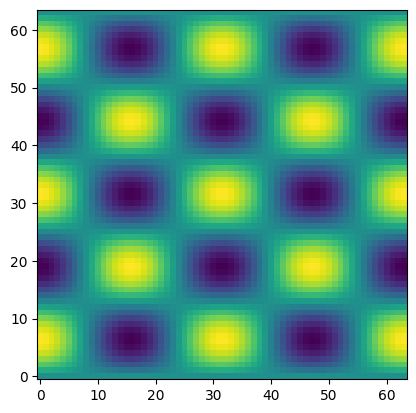

In [4]:
fig, ax = plt.subplots()
ax.imshow(d.T, origin="lower")

It often works best if you start with an existing problem.  We can inspect the source of one of the build-in problems easily:

In [5]:
from pyro.advection.problems import smooth
smooth.init_data??

To define a problem, we need to create the `init_data()` function and a list of runtime parameters needed by the problem.

First the parameters--we'll use $m$ and $n$ as the parameters we might
want to set at runtime.

In [6]:
params = {"waves.m": 4, "waves.n": 5}

Our problem initialization routine gets a `RuntimeParameters` object
passed in, so we can access these values when we do the initialization.

In [7]:
def init_data(my_data, rp):
    """ initialize the waves problem """

    dens = my_data.get_var("density")
    g = my_data.grid
    
    L_x = g.xmax - g.xmin
    L_y = g.ymax - g.ymin

    m = rp.get_param("waves.m")
    n = rp.get_param("waves.n")
    
    dens[:, :] = np.cos(m * np.pi * g.x2d / L_x) * \
                 np.sin(n * np.pi * g.y2d / L_y)

Now we can use our new problem setup.  We need to register it with the solver by using the `add_problem()` method.  Then everything works the
same as any standard problem.

In [8]:
from pyro import Pyro

In [9]:
p = Pyro("advection")
p.add_problem("waves", init_data, problem_params=params)
p.initialize_problem("waves")

We can already look at the initial conditions

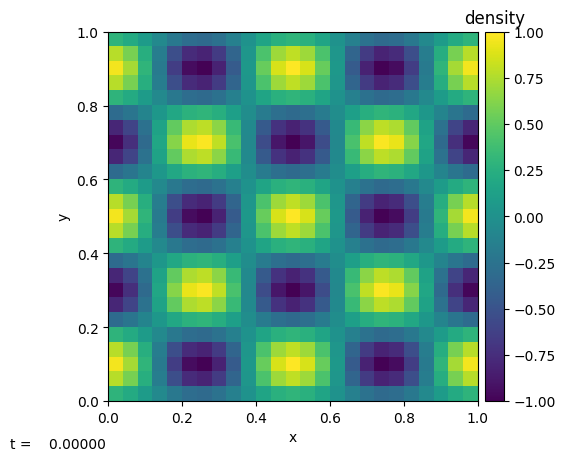

<Figure size 640x480 with 0 Axes>

In [10]:
p.sim.dovis()

If we wanted to change the number of wavelengths, we could override
the default values of the runtime parameters when we call `initialize_problem()`.

We also need to change the boundary conditions.  For problems that we 
define this way, there is not a default "inputs" file that sets up
the domain, etc. for us.  But we can see what the default value of
all the parameters for the simulation are:

In [11]:
print(p)

Solver = advection
Problem = waves
Simulation time = 0.0
Simulation step number = 0

Runtime Parameters
------------------
advection.limiter = 2
advection.u = 1.0
advection.v = 1.0
driver.cfl = 0.8
driver.fix_dt = -1.0
driver.init_tstep_factor = 0.01
driver.max_dt_change = 2.0
driver.max_steps = 10000
driver.tmax = 1.0
driver.verbose = 0
io.basename = pyro_
io.do_io = 0
io.dt_out = 0.1
io.force_final_output = 0
io.n_out = 10000
mesh.grid_type = Cartesian2d
mesh.nx = 25
mesh.ny = 25
mesh.xlboundary = reflect
mesh.xmax = 1.0
mesh.xmin = 0.0
mesh.xrboundary = reflect
mesh.ylboundary = reflect
mesh.ymax = 1.0
mesh.ymin = 0.0
mesh.yrboundary = reflect
particles.do_particles = 0
particles.n_particles = 100
particles.particle_generator = grid
vis.dovis = 0
vis.store_images = 0
waves.m = 4
waves.n = 5



The main thing we need to change is the boundary conditions--we'll make
them periodic.  We'll also set the grid size to $32^2$.

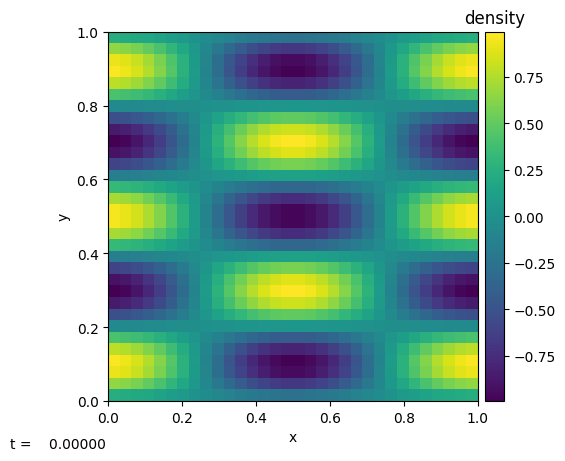

<Figure size 640x480 with 0 Axes>

In [12]:
p = Pyro("advection")
p.add_problem("waves", init_data, problem_params=params)
p.initialize_problem("waves",
                     inputs_dict={"mesh.nx": 32,
                                  "mesh.ny": 32,
                                  "mesh.xlboundary": "periodic",
                                  "mesh.xrboundary": "periodic",
                                  "mesh.ylboundary": "periodic",
                                  "mesh.yrboundary": "periodic",
                                  "waves.m": 2})
p.sim.dovis()

Now let's evolve it

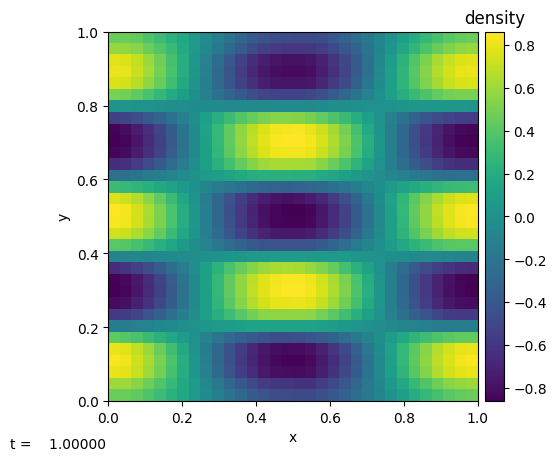

<Figure size 640x480 with 0 Axes>

In [13]:
p.run_sim()
p.sim.dovis()

The simulation is quite coarse, so the extrema are clipped a bit from the 
initial values, but we can fix that by increasing `mesh.nx` and `mesh.ny`.